# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [2]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
classes = ['SNIa', 'SNIbc', 'SNII']  # These are the classes that will be classified

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
            'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
            'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
            'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
            'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y','HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
            'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
            'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
            'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
            'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [3]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Only alert_name columns are considered
    df = df[alert_name]

    subclass = filename.replace('_HEAD.FITS.gz', '').replace('data_rn/', '')  # Name of the subclass
    subclasses = [subclass for x in range(len(df))]  # List of strings containing the name of the subclass

    _class_ = subclass[:4]  # Name of the class
    classes = [_class_ for x in range(len(df))]  # List of strings containing the name of the class

    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', subclasses)
    df.insert(0, 'CLASS', classes)
    df.replace(['SNIb', 'SNIc'], 'SNIbc', inplace=True)

    return df


In [4]:
dataframes = [to_df(filename) for filename in head_filenames]

df_train = pd.concat(dataframes)
df_train

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60442.4130,i,-1.563279,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60444.4280,r,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4187,Y,-17.873014,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4293,z,12.042594,25.301315
4,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.3

In [6]:
df = df_train[['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']].copy()
df

,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
0,31254142,SNII,60442.4130,i,-1.563279,11.344539
1,31254142,SNII,60444.4280,r,3.731861,4.645030
2,31254142,SNII,60457.4187,Y,-17.873014,42.014057
3,31254142,SNII,60457.4293,z,12.042594,25.301315
4,31254142,SNII,60463.4195,i,2.557573,6.018558
...,...,...,...,...,...,...
118810,15480123,SNIbc,60961.0854,i,-10.518693,8.376203
118811,15480123,SNIbc,60961.1019,z,8.501602,15.873994
118812,15480123,SNIbc,60967.0495,r,1.206127,3.369061
118813,15480123,SNIbc,60967.0664,i,-8.784276,3.759806


### Visualization of data

A count plot, 20 lightcurves per class and histograms are presented.

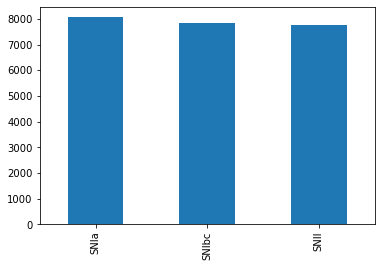

In [7]:
ax = df_train.groupby('SNID').max().CLASS.value_counts().plot.bar()

In [8]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

In [9]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                        yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None:
        fig.savefig(path+'lc_'+SNID+'.png')

In [10]:
np.random.seed(73)

snids_20sample = [list(df_train.loc[df_train.CLASS.isin([df_train.CLASS.unique()[i]])].sample(
    20).SNID) for i in range(len(df_train.CLASS.unique()))]

snids_20 = sum(snids_20sample, [])

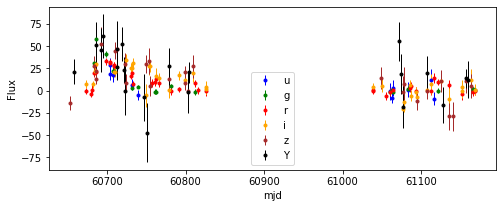

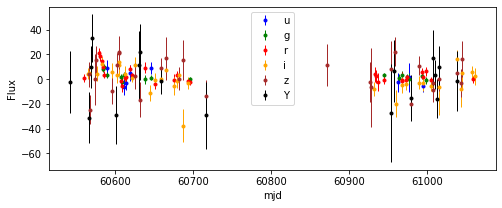

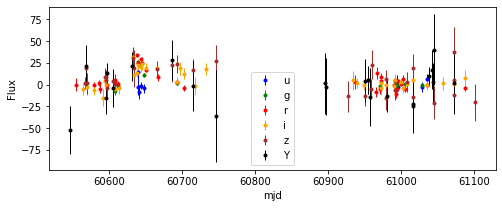

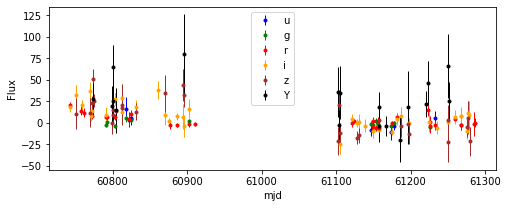

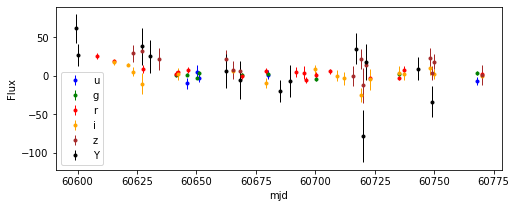

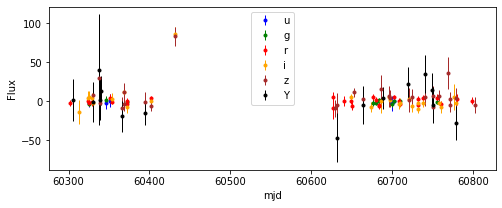

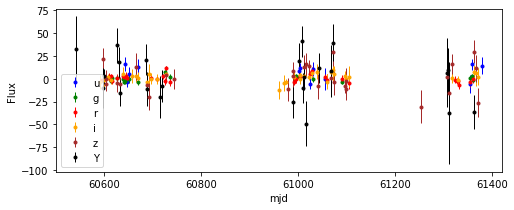

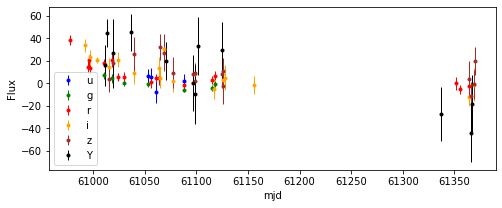

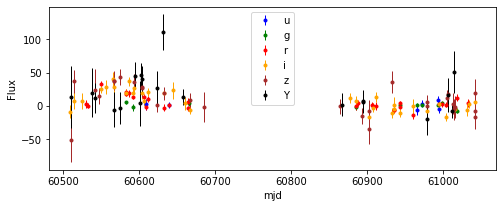

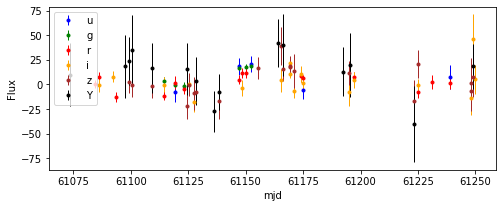

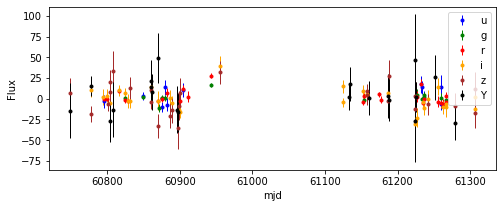

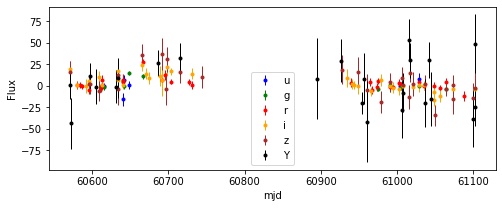

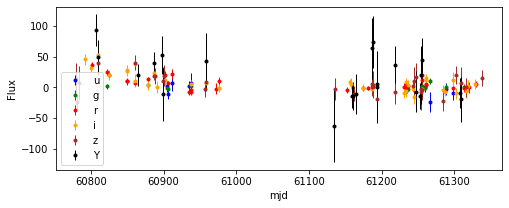

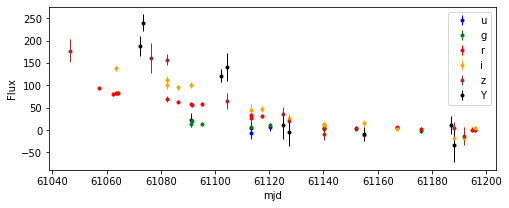

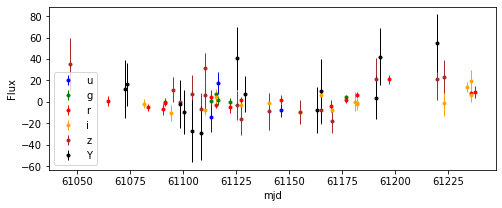

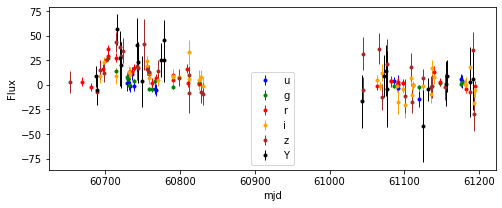

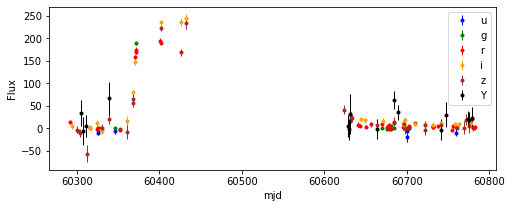

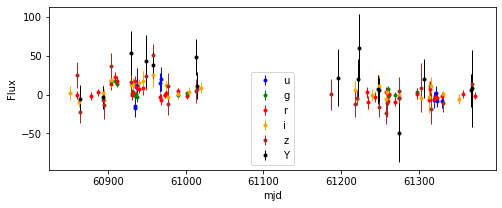

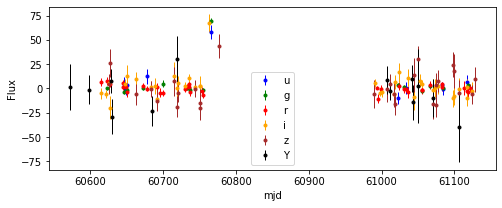

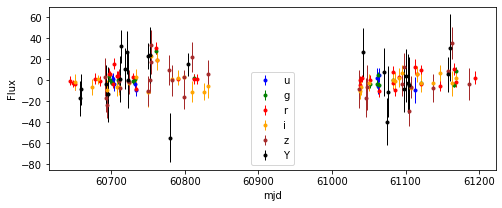

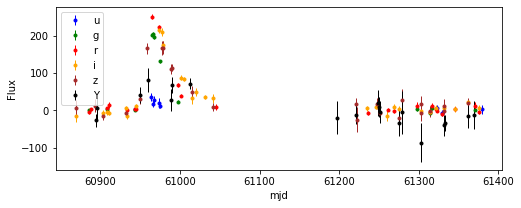

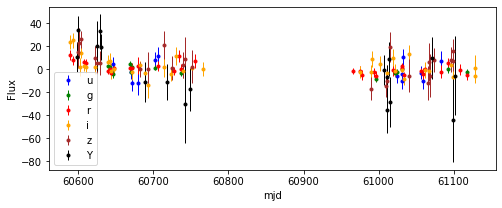

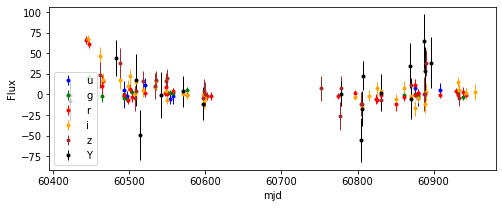

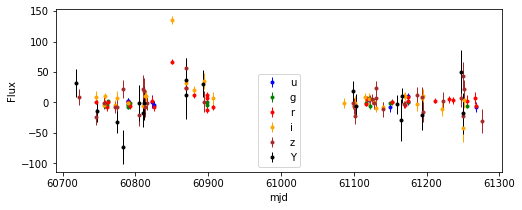

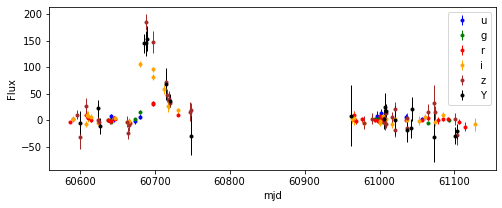

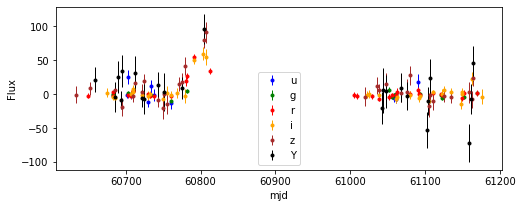

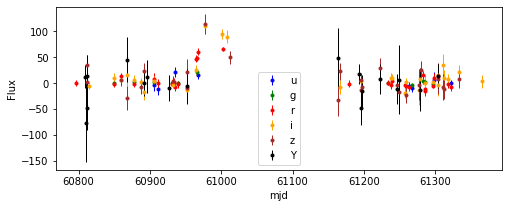

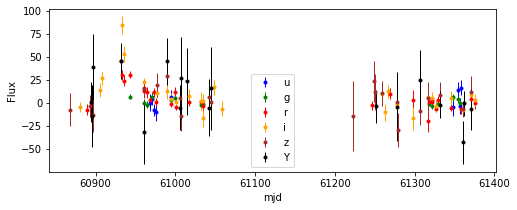

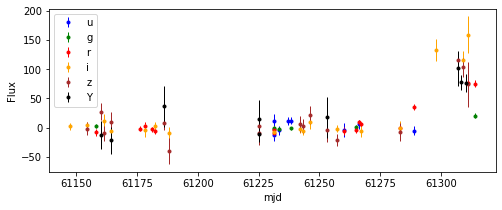

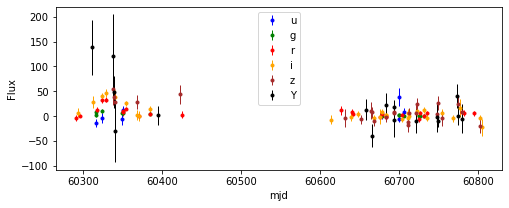

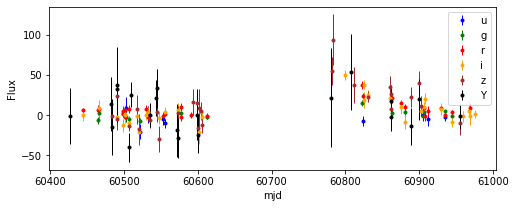

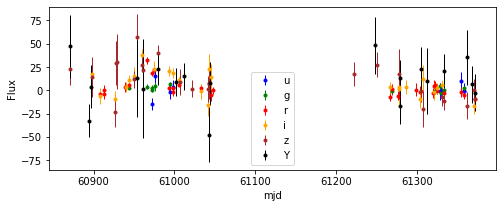

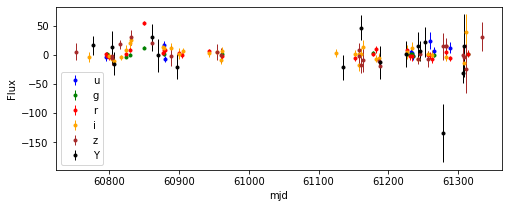

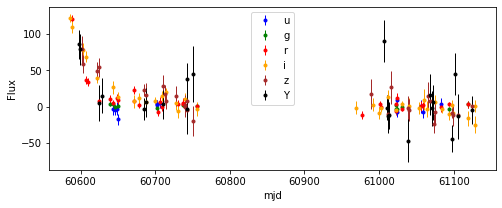

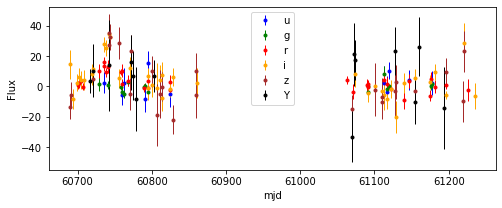

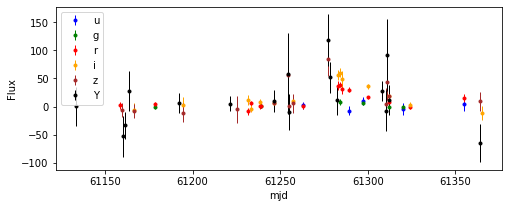

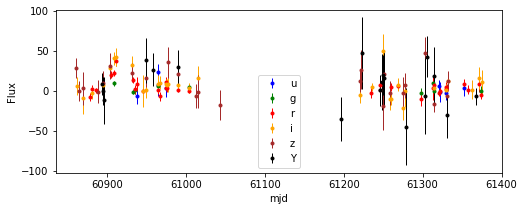

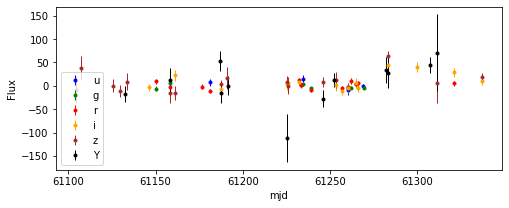

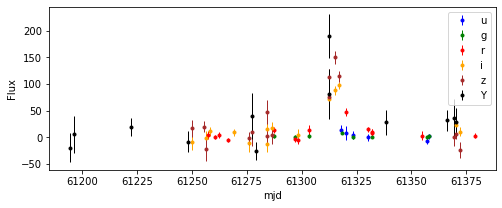

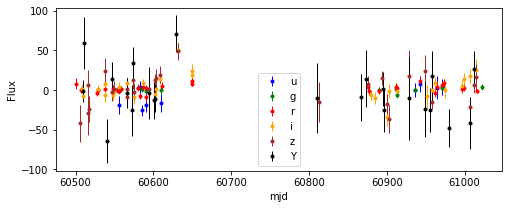

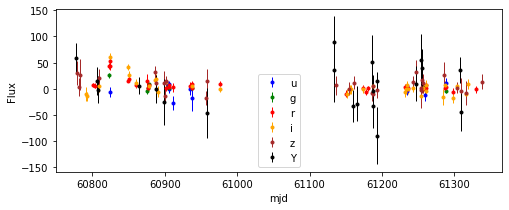

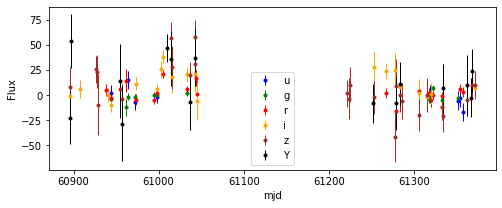

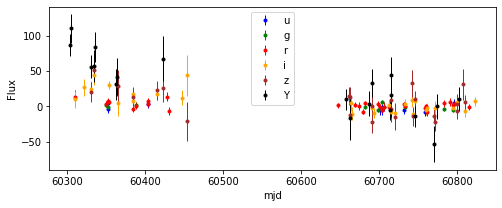

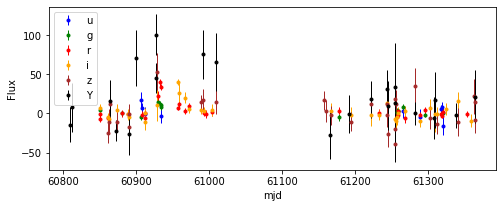

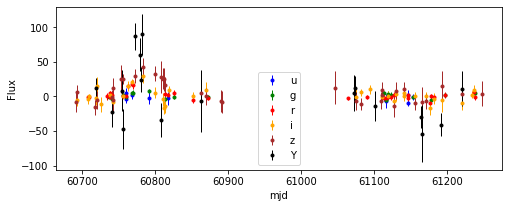

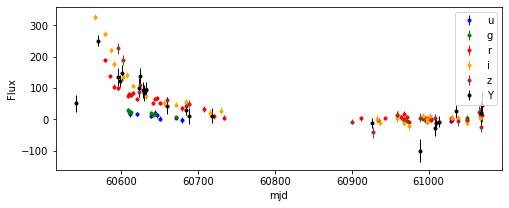

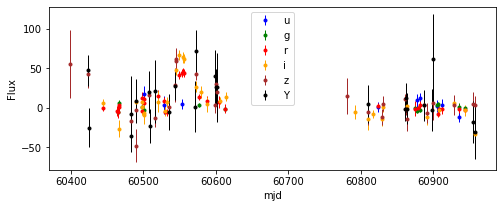

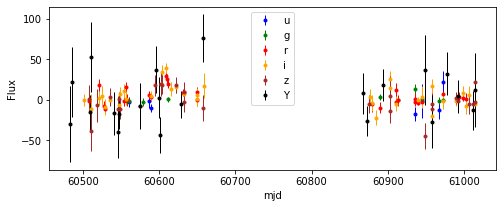

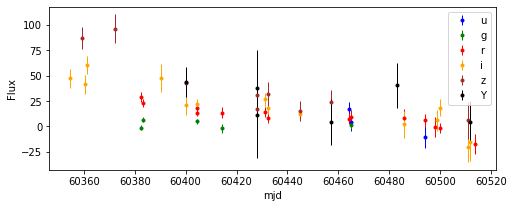

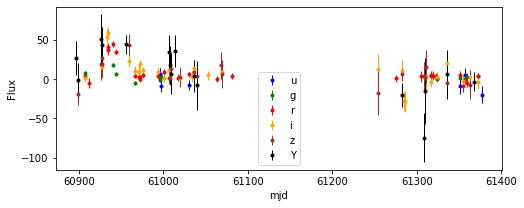

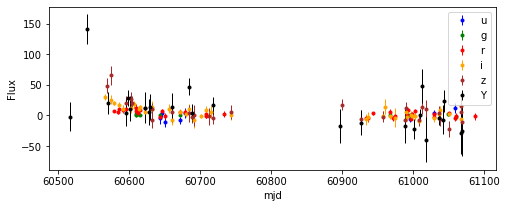

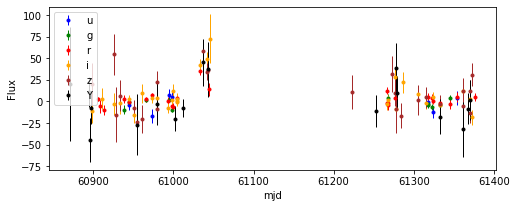

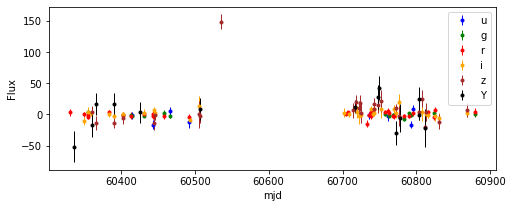

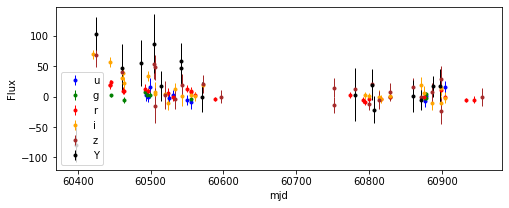

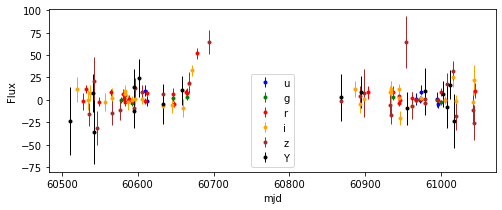

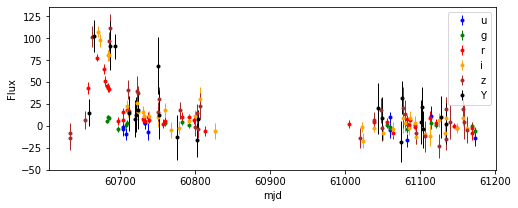

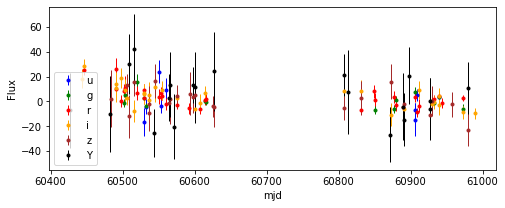

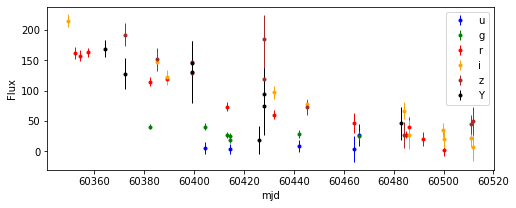

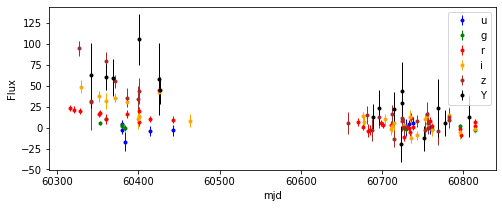

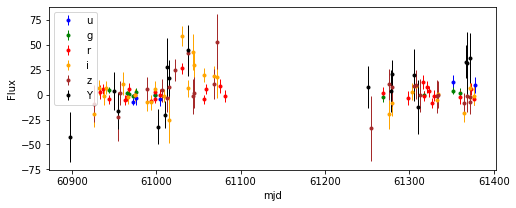

In [98]:
for snid in snids_20:
    plot_lc(str(snid), df_train, path='images/lightcurves/')
    plt.show()

In [11]:
snids_array = df_train.SNID.unique()

Text(0.5, 1.0, 'Flux histogram')

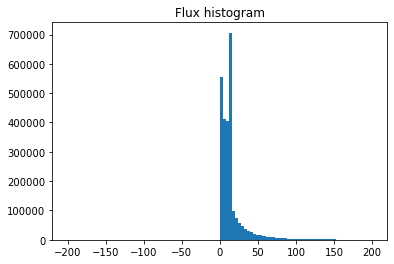

In [12]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(
    df_train.FLUXCAL.to_numpy(), bins=100, range=(-200, 200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux histogram')

Text(0.5, 1.0, 'Flux error histogram')

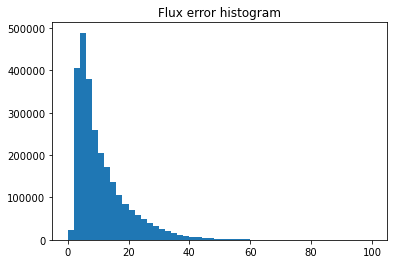

In [13]:
# Flux Error Histogram
counts, bins = np.histogram(
    df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux error histogram')

Text(0.5, 1.0, 'Signal to noise ratio histogram')

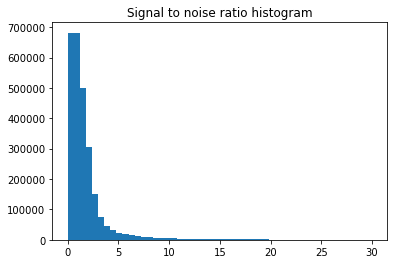

In [14]:
# SNR Histogram
counts, bins = np.histogram(df_train.FLUXCAL.to_numpy(
)/df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Signal to noise ratio histogram')


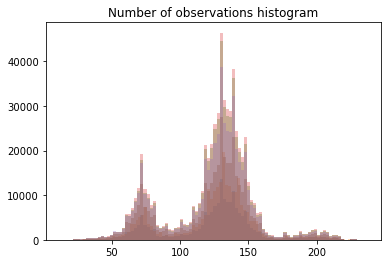

In [15]:
# Number of observations Histogram

fig, ax = plt.subplots()
for c in list(colors.keys()):
    counts, bins = np.histogram(df_train.loc[df_train.BAND == c].NOBS.to_numpy(), bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram');

## Building images

The goal of this section is to build images so a Neural Network can perform classification.

Since most of the objects have a NOBS higher than 60, images will consist in matrixes of 6 x 60, where each row will represent a band.

In [17]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_train.BAND = encoder.fit_transform(df_train.BAND)

color = np.sort(df_train.BAND.unique())
color

array([0, 1, 2, 3, 4, 5])

To split the data into training and test sets, the fact that the dataframe contains multiple rows for an object needs to be considered. So, the array containing the SNID's (`snids_array`) will be splitted into a train and test array.

In [18]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

snids_train, snids_test = train_test_split(snids_array, test_size=0.4, random_state=1)

In [19]:
X_df_train = df_train.loc[df_train.SNID.isin(snids_train)].drop(['CLASS', 'SUBCLASS'], axis=1)
X_df_test = df_train.loc[df_train.SNID.isin(snids_test)].drop(['CLASS', 'SUBCLASS'], axis=1)

y_train = df_train.loc[df_train.SNID.isin(snids_train)]['CLASS']
y_test = df_train.loc[df_train.SNID.isin(snids_test)]['CLASS']

In [20]:
X_df_train = X_df_train[['SNID', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']]
X_df_test = X_df_test[['SNID', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']]

In [21]:
X_df_train.SNID

124       88298320
125       88298320
126       88298320
127       88298320
128       88298320
            ...   
118810    15480123
118811    15480123
118812    15480123
118813    15480123
118814    15480123
Name: SNID, Length: 1575994, dtype: object

In [36]:
# Attempt to do it like the paper
snids_train = X_df_train.SNID.unique()

# Matrix is defined
X60_train_time = np.zeros((len(snids_train), 6, 60))


for i in range(len(snids_train)):
    for c in color:
        mask = (df_train.SNID == snids_train[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].MJD.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_train_time[c] = output

In [50]:
X60_train_flux = np.zeros((len(snids_train), 6, 60))

for i in range(len(snids_train)):
    for c in color:
        mask = (df_train.SNID == snids_train[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].FLUXCAL.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_train_flux[c] = output

In [51]:
X60_train_fluxerr = np.zeros((len(snids_train), 6, 60))

for i in range(len(snids_train)):
    for c in color:
        mask = (df_train.SNID == snids_train[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].FLUXCALERR.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_train_fluxerr[c] = output

In [52]:
X60_test_times = np.zeros((len(snids_test), 6, 60))

for i in range(len(snids_test)):
    for c in color:
        mask = (df_train.SNID == snids_test[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].MJD.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_test_times[c] = output

In [53]:
X60_test_flux = np.zeros((len(snids_test), 6, 60))

for i in range(len(snids_test)):
    for c in color:
        mask = (df_train.SNID == snids_test[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].FLUXCAL.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_test_flux[c] = output

In [54]:
X60_test_fluxerr = np.zeros((len(snids_test), 6, 60))

for i in range(len(snids_test)):
    for c in color:
        mask = (df_train.SNID == snids_test[i]) & (df_train.BAND == c)
        data = df_train.loc[mask].FLUXCALERR.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_test_fluxerr[c] = output

In [42]:
# To save the 3D array, it needs to be reshaped into a 2D one.
X60_train_time_reshaped = X60_train_time.reshape(X60_train_time.shape[0], -1)

np.savetxt('times_matrix.csv', X60_train_time_reshaped)

In [60]:
imgs = {'time_train': X60_train_time, 'flux_train': X60_train_flux, 'fluxerr_train': X60_train_fluxerr,
        'time_test': X60_test_times, 'flux_test': X60_test_flux, 'fluxerr_test': X60_test_fluxerr}


In [69]:
# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))

In [45]:
# Loading the arrays
for img in ['time_train.csv', 'flux_train.csv', 'fluxerr_train.csv', 'time_test.csv', 'flux_test.csv', 'fluxerr_test.csv']:
    np.loadtxt(img)

original_array = loaded_array.reshape(loaded_array.shape[0], loaded_array.shape[1] // 60, 60 )

In [90]:
df_train.loc[df_train.SNID == '31254142']

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_g-r,HOSTGAL_u-r,HOSTGAL_i-z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_g-r,HOSTGAL2_u-r,HOSTGAL2_i-z,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60442.4130,2,13.188386,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60444.4280,3,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60457.4187,0,14.859897,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60457.4293,5,12.042594,25.301315
4,SNII,SNI

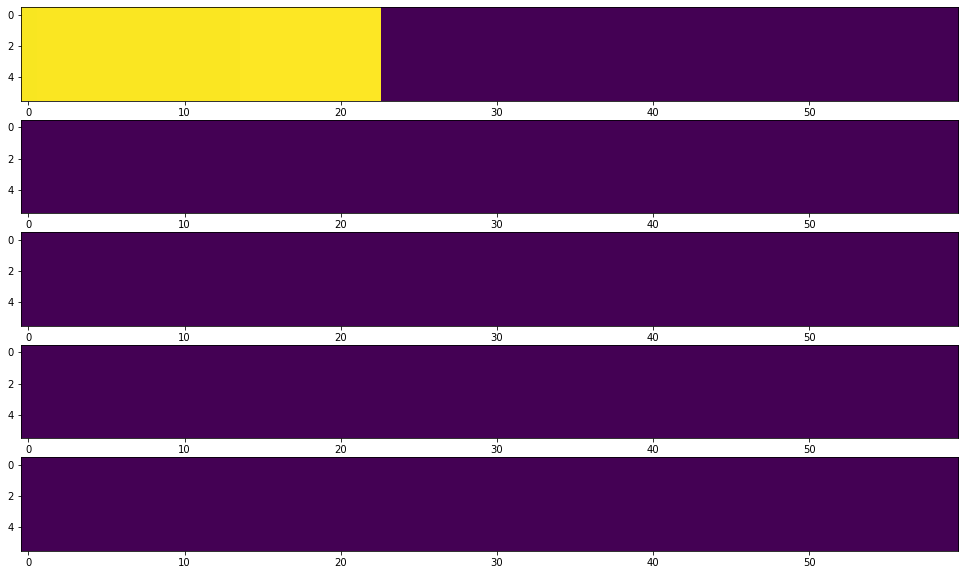

In [89]:
fig, ax= plt.subplots(5, figsize=(50,10))

for i in range(5, 10):
    ax[i - 5].imshow(X60_train_time[i], vmin=0)

In [82]:
snids_array[0]

'31254142'

In [85]:
df_train.loc[df_train.SNID == '31254142']

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_g-r,HOSTGAL_u-r,HOSTGAL_i-z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_g-r,HOSTGAL2_u-r,HOSTGAL2_i-z,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60442.4130,2,13.188386,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60444.4280,3,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60457.4187,0,14.859897,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.1411,22.007923,0.077,0.00882,0.0062,0.00644,0.00792,0.691353,1.64152,0.200663,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.890722,2.037239,0.29771,0.005,0.005,0.005,0.00501,60457.4293,5,12.042594,25.301315
4,SNII,SNI

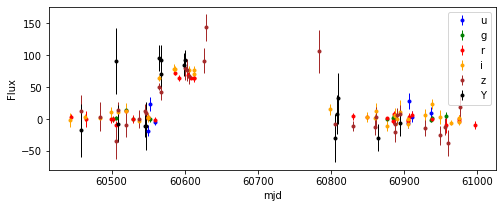

In [99]:
plot_lc('31254142', df_train)

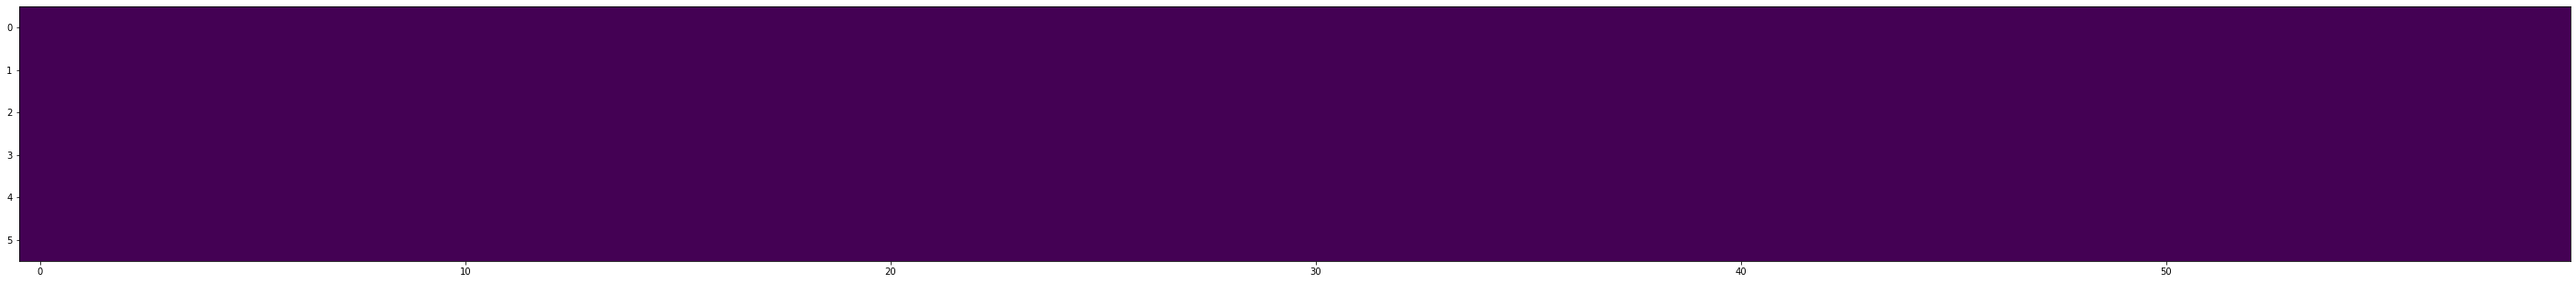

In [103]:
fig, ax= plt.subplots(figsize=(50,10))
ax.imshow(X60_train_flux[205], vmin=0)

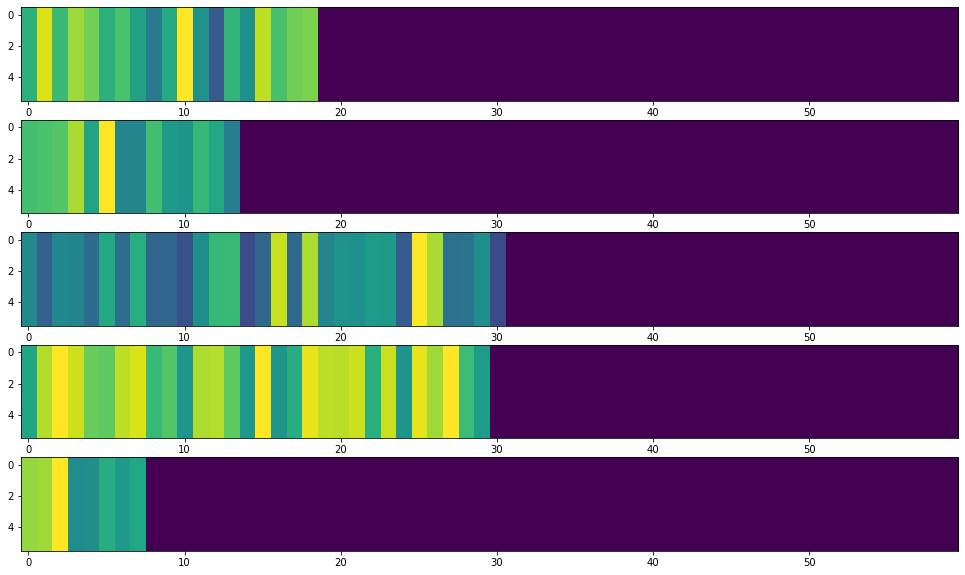

In [76]:
fig, ax= plt.subplots(5, figsize=(50,10))

for i in range(5):
    ax[i].imshow(X60_train_fluxerr[i], vmin=0)